## Function for fetching and loading data    

In [290]:
from __future__ import division, print_function, unicode_literals

import numpy as np
import os
import pandas as pd
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

## Looking at the data structure

In [291]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [292]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


#### 2 Things To Notice
 - total_bedrooms only has 20433 instances meaning than 207 districts are missing this value
 - ocean_proximity is an object, since this data was loaded from a CSV this means its a categorical variable

In [293]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [294]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


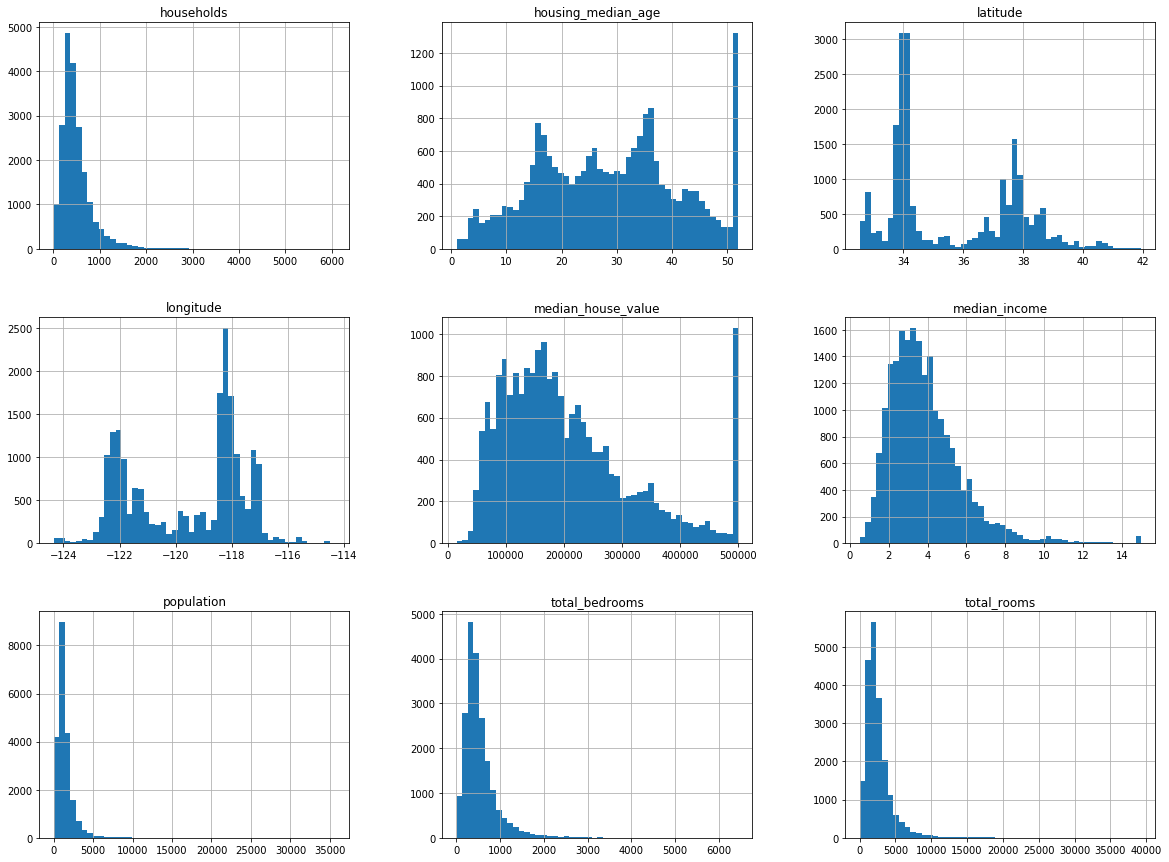

In [295]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

#### 5 Things To Notice
 - median_income does not seem to be expressed in USD
 - households, population, total_bedrooms, and total_rooms all have similar histograms suggesting a correlation
 - median_age and median_house_value are capped, this is especially a problem for household value since this is our target attribute and we don't want our MLA to think that prices cannot go beyond that cap
 - all these attributes have very different scales (x axis)
 - these histograms are tail heavy which MLA's have a harder time with, solution is to transform them into a bell shape

## Create a Test Set

In [296]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]   

#### Using this function on the housing data set for an 80/20 train/test split

In [297]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


#### 1 Thing To Notice
- this function will generate a differest test set every time its run which will allow the MLA to eventually view all samples over time

#### If you hash all instances and store their last byte then you can check to see if the last byte of an instance is lower or equal to 51 (20% of 256) and add it to the test set. Since the Housing data does not have unique ID's you need to get creative - Using a combo of a districts Longitute and Latitude provides a unique value for each instance

In [298]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1]<256*test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

## using Longitude and latitude to make id column
housing_with_id = housing.reset_index()
housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

train_set.info()
test_set.info()




<class 'pandas.core.frame.DataFrame'>
Int64Index: 16267 entries, 0 to 20639
Data columns (total 12 columns):
index                 16267 non-null int64
longitude             16267 non-null float64
latitude              16267 non-null float64
housing_median_age    16267 non-null float64
total_rooms           16267 non-null float64
total_bedrooms        16108 non-null float64
population            16267 non-null float64
households            16267 non-null float64
median_income         16267 non-null float64
median_house_value    16267 non-null float64
ocean_proximity       16267 non-null object
id                    16267 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 1.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4373 entries, 8 to 20636
Data columns (total 12 columns):
index                 4373 non-null int64
longitude             4373 non-null float64
latitude              4373 non-null float64
housing_median_age    4373 non-null float64
total_roo

#### Scikit-Learn has the train_test_split function which does the same thing as split_train_test defined earlier

In [299]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

#### Dealing with Sampling Bias: Use Stratified Sampling
- look at the histogram of the attribute to see if this is necessary
- divide the attribute into subgroups (strata)
- use Scikit-Learn's StratifiedShuffleSplit to get stratified test sets

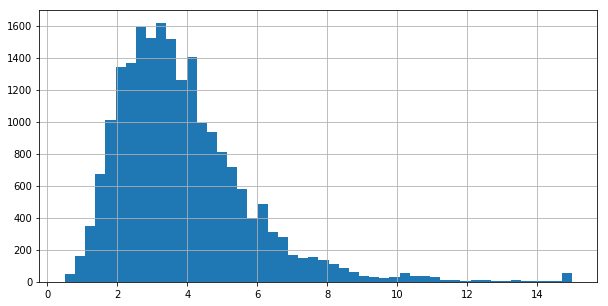

In [300]:
%matplotlib inline
import matplotlib.pyplot as plt
housing["median_income"].hist(bins=50, figsize=(10,5))
plt.show()

#### median_income is clustered around 2-4, with some values much higher. We want to make sure this distribution is matched in our test set

In [301]:
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [302]:
housing["income_cat"].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

#### Don't forget to drop the income_cat created for stratification so that the data sets return to normal

In [303]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## Discover and Visualize to Gain Insights

In [304]:
housing = strat_train_set.copy() #copy of training data so we don't mess up the original

#### Visualizing Geographical Data

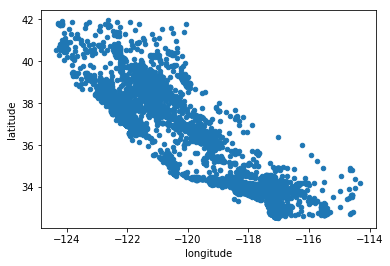

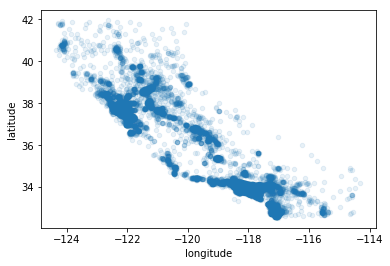

In [305]:
housing.plot(kind="scatter", x="longitude", y="latitude") #with no alpha
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1) #with alpha

#### Adding in Price

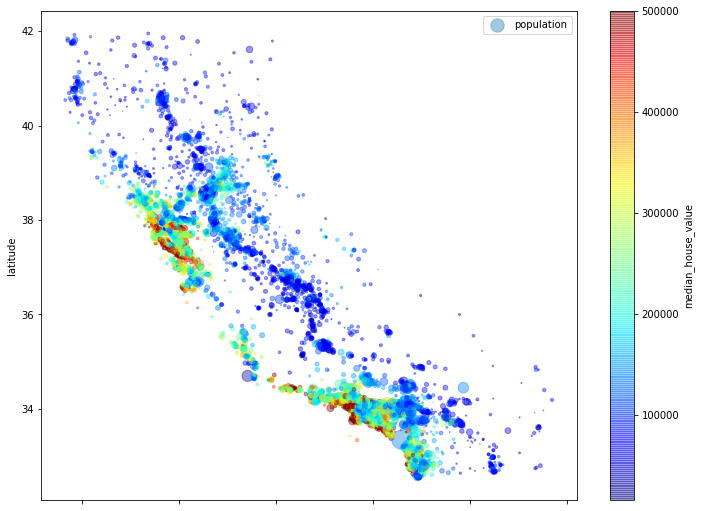

In [306]:
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

#### 3 Thing To Notice
- Population is scattered arround costal regions and in the central valley
- house prices are highest near the coast and in the bay area
- a clutering algorithm can be used to detect the main clusters and add a new feature (proximity to cluster center) that can help strengthen the model

#### Now Lets Look for Correlations

In [307]:
# Standard correlation matrix
corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

#### 2 Things to Notice
- median_income is the most promising attribute for predicting median_house_value
- latitude has a slight negative correlation meaning that houses tend to get slightly cheaper as you go north

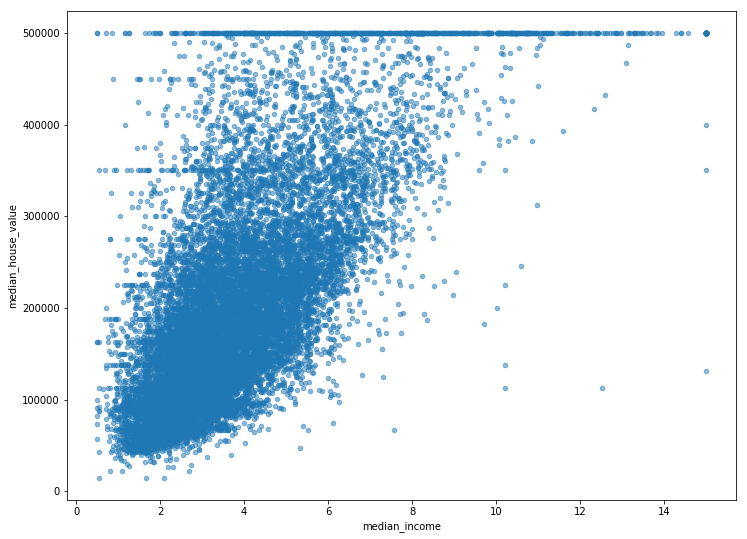

In [308]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.5)

#### 3 Things to Notice
- there is indeed a fairl strong correlation
- there is a horizontal line at the price cap of 500,000
- there are also horizontal lines at 450,000 and 350,000 which means there may be different price caps by district

## Experiementing with Attribute Combinations

In [309]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

#correlation
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

#### 2 Things to Notice
- bedrooms_per_room is more correlated than either of the two attributes were seperately, apparently houses with low bedrooms/room ratio are more expensive
- rooms_per_household is also positively correlated which makes sense since bigger houses tend to be more expensive

## Preparing the Data for Machine Learning Algorithms

In [310]:
#Start with a copy of training data with the predictors separated
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### MLA's cannot work with missing features, need to take care of attributes with missing values
#### You can do this the following ways:
- get rid of entire corresponding district
- get rid of the entire attribute
- set the values to something neutral (zero, mean, median)

In [311]:
h1 = housing.dropna(subset=["total_bedrooms"]) #entire district
h2 = housing.drop("total_bedrooms", axis=1) #entire attribute
median=housing["total_bedrooms"].median()
h3 = housing["total_bedrooms"].fillna(median) #neutral value

#### Can also use Scikit-Learn "Imputer"

In [312]:
from sklearn.impute import SimpleImputer as Imputer

imputer = Imputer(strategy="median")

#can only be computed on numerical values so need to drop ocean_proximity
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
imputer.statistics_

#now used trained imputer to replace missing values by learned medians
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

#### Text and Categorical Attributes

In [313]:
# Ocean proximity needs to be converted to numbers
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [314]:
# You can use the following to view which class is mapped to which number
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [315]:
# An even better strategy is to make each class its own binary categorical variable (one-hot encoding)
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

c:\users\yanick\miniconda3\envs\ml\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [316]:
# you can do this in one step with scikit's LearnBinarizer
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [317]:
# if there is a ton of data you can transform into a sparse matrix 
encoder = LabelBinarizer(sparse_output = True)
housing_cat_1hot_sparse = encoder.fit_transform(housing_cat)
housing_cat_1hot_sparse

<16512x5 sparse matrix of type '<class 'numpy.int32'>'
	with 16512 stored elements in Compressed Sparse Row format>

#### Creating Custom Transformers

In [318]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)

Honestly not sure what the purpose of this is, I assume it has to do with the fact that Scikit-Learn doesn't use the Numpy data structure and needs a way of identifying columns?

## Transformation Pipeline

In [319]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Important to note that this is a pipeline for numerical values only and that there is also a need to apply the LabelBinarizer ont he categorical values

In [320]:

try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20
    
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)


Now run the whole pipeline on the housing data

In [321]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

Need to write another custom transformer so that Scikit-Learn can handle Pandas DataFrame

In [322]:
from sklearn.base import BaseEstimator, TransformerMixin

class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

## Select and Train Model

#### Linear Regression Model

In [323]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [324]:
# testing it out
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Looks pretty good but lets see the actual error output

In [325]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

Knowing that house prices range from 120K to 265K typically a standard error of 69K is not good enough

#### 3 Ways to Improve the Model
- select a more powerful model
- feed training algorithm with more features
- recude the constraints on the model (model must be regularized)

#### DecisionTreeRegressor (a more powerful model)

In [326]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [327]:
# testing it out
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", tree_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [286600. 340600. 196900.  46300. 254500.]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Looks bang on! lets check to make sure

In [328]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

#### 1 Thing to Notice
- if the model seems perfect, it probably just mean that it has badly overfitted the data

## Evaluating the Model Using Cross-Validation

You could use train_test_split to creat a validation set from the training set or you could just use Scikit-Learn cross-validation feature that creates 10 random subsets which it uses to train and evaluate the model 10 times, but ya know up to you

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
rmse_score = np.sqrt(-scores)

In [330]:
# Simple function for displaying results
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [331]:
display_scores(rmse_score)

Scores: [68075.64108131 64931.35711633 70167.02090506 69958.14474925
 71312.87044694 76352.05569999 70493.79382739 71810.53140309
 75383.36370099 68977.92239722]
Mean: 70746.27013275513
Standard Deviation: 3153.9514701315497


#### 1 Thing to Notice
- This is actually WORSE than the linear regression model, which means that the decision tree model is badly overfitting

In [332]:
# Linear regression model scores
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard Deviation: 2731.6740017983425


#### RandomForestRegressor

In [333]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

# scoring the model
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

c:\users\yanick\miniconda3\envs\ml\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores: [50791.83078912 50017.48279133 52207.65574994 53958.85322063
 52962.56765933 56586.39113885 52132.72495091 50001.49801054
 55476.0562367  52752.113812  ]
Mean: 52688.71743593361
Standard Deviation: 2077.227612668562


#### Saving Models

In [334]:
from sklearn.externals import joblib
joblib.dump(lin_reg, "lin_reg.pkl")
joblib.dump(tree_reg, "tree_reg.pkl")
joblib.dump(forest_reg, "forest_reg.pkl")

# load models using
loaded_model = joblib.load("lin_reg.pkl")

## Fine-Tuning the Model

#### Grid Search for Selecting Hyper Parameters
this part I don't quite understand yet so I took it from source repo

In [335]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [336]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [337]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [339]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.05791727153 {'max_features': 2, 'n_estimators': 3}
55627.16171305252 {'max_features': 2, 'n_estimators': 10}
53384.57867637289 {'max_features': 2, 'n_estimators': 30}
60965.99185930139 {'max_features': 4, 'n_estimators': 3}
52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
58663.84733372485 {'max_features': 6, 'n_estimators': 3}
52006.15355973719 {'max_features': 6, 'n_estimators': 10}
50146.465964159885 {'max_features': 6, 'n_estimators': 30}
57869.25504027614 {'max_features': 8, 'n_estimators': 3}
51711.09443660957 {'max_features': 8, 'n_estimators': 10}
49682.25345942335 {'max_features': 8, 'n_estimators': 30}
62895.088889905004 {'n_estimators': 3, 'bootstrap': False, 'max_features': 2}
54658.14484390074 {'n_estimators': 10, 'bootstrap': False, 'max_features': 2}
59470.399594730654 {'n_estimators': 3, 'bootstrap': False, 'max_features': 3}
52725.01091081235 {'n_estimators': 10, 'bootstrap': False, 'max_features

looks like with max_features set to 8 and n_estimators set to 30 we get the best result

#### Gid Search is fine when exploring relatively few combinations but when you have a LARGE search space you want to use RandomizedSearchCV for two main reasons:
- if you run 1000 iterations it will produce 1000 different values for each hyperparameter, instead of the few values that you can manually assign with grid search
- you have control over the computing budget by setting the number of iterations

#### Another thing you can do is ensemble more models to see if the performance is better

#### Its also good to use your model to see the relative importance of your features

In [341]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [342]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

#### 3 Things to Notice
- only one of the ocean_proximity classes are actualy important 'Inland' so dropping the rest may help improve the model
- some of the numerical features with the lower importance could also be dropped 
- outliers could be contributing significantly to this

## Evaluating System on Test Set

In [344]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [345]:
final_rmse

47730.22690385927

### Done :)